In [1]:
def compute_region_averages(df):
    REGION_MAP = {
        "forefoot": [5, 6, 7, 8, 9, 12, 15, 16],
        "midfoot": [1, 2, 10, 11, 13, 14],
        "rearfoot": [3, 4]
    }
    for region, indices in REGION_MAP.items():
        sensor_cols = [f"FSR_{i}" for i in indices]
        df[region] = df[sensor_cols].mean(axis=1)
    return df

def compute_derivatives(df, time_col="time_sec"):
    df["d_rearfoot"] = df["rearfoot"].diff() / df[time_col].diff()
    df["d_forefoot"] = df["forefoot"].diff() / df[time_col].diff()
    df["dd_forefoot"] = df["d_forefoot"].diff() / df[time_col].diff()
    return df

import pandas as pd
from decimal import Decimal

def preprocess_sensor_dataframe(data):
    """
    Converts raw JSON data to a preprocessed DataFrame suitable for gait event detection.

    Steps:
    - Flattens JSON structure
    - Converts Decimal to float
    - Clips FSR values to [0, 4095]
    - Adds time_sec column (relative time)
    - Replaces FSR_14 with FSR_11 due to hardware wiring

    Returns:
        Preprocessed pandas DataFrame
    """
    # Convert to DataFrame and flatten JSON
    df = pd.json_normalize(data)

    # Convert Decimal to float
    df = df.map(lambda x: float(x) if isinstance(x, Decimal) else x)

    # Sort by timestamp
    df = df.sort_values(by="timestamp").reset_index(drop=True)

    # Ensure all FSR columns exist and clip values
    for i in range(1, 17):
        col = f"FSR_{i}"
        if col not in df.columns:
            df[col] = 0.0  # Fill missing columns with zeros
        df[col] = df[col].clip(0, 4095)

    # Replace FSR_14 with FSR_11 (due to hardware wiring)
    df["FSR_14"] = df["FSR_11"]

    # Create time_ms_sec relative to session start
    df["rel_time_ms"] = (df["timestamp"] - df["timestamp"].min())

    return df



In [2]:
from scipy.signal import find_peaks

def detect_ic_to(df, time_col="rel_time_ms"):
    df = df.copy()
    df = compute_region_averages(df)
    df = compute_derivatives(df, time_col)

    # --- Detect ICs ---
    ic_peaks, _ = find_peaks(df["d_rearfoot"], height=10, distance=5)
    ic_times = df[time_col].iloc[ic_peaks].to_list()

    # --- Detect TOs using raw ay and dd_forefoot ---
    forefoot_peaks, _ = find_peaks(df["forefoot"], height=500)
    ay_peaks, _ = find_peaks(df["ay"], height=2)
    dd_neg_peaks, _ = find_peaks(-df["dd_forefoot"], height=0.05)

    to_times = []
    to_labels = []

    for fp_idx in forefoot_peaks:
        after = df["forefoot"].iloc[fp_idx:].reset_index(drop=True)
        zero_cross = after[after < 100]
        if len(zero_cross) == 0:
            continue
        zc_idx = fp_idx + zero_cross.index[0]
        mid_idx = (fp_idx + zc_idx) // 2

        dd_peaks = [i for i in dd_neg_peaks if fp_idx < i < zc_idx]
        ay_peaks_in_range = [i for i in ay_peaks if fp_idx < i < zc_idx]

        if dd_peaks and ay_peaks_in_range:
            to_times.append(df[time_col].iloc[dd_peaks[0]])
            to_labels.append("dd")
        elif dd_peaks:
            to_times.append(df[time_col].iloc[dd_peaks[0]])
            to_labels.append("dd")
        elif ay_peaks_in_range:
            to_times.append(df[time_col].iloc[ay_peaks_in_range[0]])
            to_labels.append("ay")
        elif df["dd_forefoot"].iloc[mid_idx] < 0:
            to_times.append(df[time_col].iloc[mid_idx])
            to_labels.append("mid")

    return {
        "ic_times": ic_times,
        "to_times": to_times,
        "to_labels": to_labels
    }


In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_ic_to(df, ic_times, to_times, to_labels, time_col="rel_time_ms"):
    # Colors for TO markers
    colors = {"dd": "red", "ay": "blue", "mid": "orange"}

    # Compute region-wise pressures and derivatives
    df = compute_region_averages(df)
    df = compute_derivatives(df, time_col)

    fig, axs = plt.subplots(4, 1, figsize=(14, 18))

    # 1. Region Pressure
    for region in ["forefoot", "midfoot", "rearfoot"]:
        axs[0].plot(df[time_col], df[region], label=region.capitalize())
    for t in ic_times:
        axs[0].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[0].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[0].set_title("Region-wise Pressure with IC (green) and TO Markers")
    axs[0].legend()
    axs[0].grid(True)

    # 2. d_rearfoot + d_forefoot
    axs[1].plot(df[time_col], df["d_rearfoot"], label="d(Rearfoot)", color="green")
    axs[1].plot(df[time_col], df["d_forefoot"], label="d(Forefoot)", color="blue")
    for t in ic_times:
        axs[1].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[1].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[1].set_title("First Derivative of Pressure (Slopes)")
    axs[1].legend()
    axs[1].grid(True)

    # 3. dd_forefoot
    axs[2].plot(df[time_col], df["dd_forefoot"], label="dd(Forefoot)", color="red")
    for t in ic_times:
        axs[2].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[2].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[2].set_title("Second Derivative of Forefoot Pressure")
    axs[2].legend()
    axs[2].grid(True)

    # 4. ay raw
    axs[3].plot(df[time_col], df["ay"], label="ay (raw)", color="purple")
    for t in ic_times:
        axs[3].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[3].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[3].set_title("Vertical Acceleration ay")
    axs[3].set_ylabel("Acceleration (m/s²)")
    axs[3].legend()
    axs[3].grid(True)

    # Set x-axis formatting for all subplots
    for i, ax in enumerate(axs):
        ax.set_xlabel("Relative Time (ms since session start)")
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))

    # Add legend as a separate figure element
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color='red', linestyle='--', label='TO via dd_forefoot'),
            plt.Line2D([0], [0], color='blue', linestyle='--', label='TO via ay peak'),
            plt.Line2D([0], [0], color='orange', linestyle='--', label='Fallback midpoint'),
            plt.Line2D([0], [0], color='green', linestyle='--', alpha=0.5, label='IC'),
        ],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=4,
        fontsize=10
    )

    plt.tight_layout(pad=3.0)  # Increase padding between subplots
    plt.subplots_adjust(bottom=0.08)  # Make room for the legend
    plt.show()

In [4]:
import numpy as np

def compute_valid_stride_times(ic_times, multiplier=1.75):
    """
    Filters stride intervals based on a median threshold rule.

    Args:
        ic_times (list of float): Initial Contact timestamps in seconds
        multiplier (float): Max allowed stride duration as a multiple of median

    Returns:
        stride_times (list of float): Valid stride durations (in seconds)
        valid_ic_pairs (list of tuple): (IC_start, IC_end) for valid strides
    """
    if len(ic_times) < 2:
        return [], []

    ic_intervals = np.diff(ic_times)
    median_stride = np.median(ic_intervals)
    upper_limit = multiplier * median_stride

    stride_times = []
    valid_ic_pairs = []

    for i, delta in enumerate(ic_intervals):
        if delta <= upper_limit:
            stride_times.append(delta)
            valid_ic_pairs.append((ic_times[i], ic_times[i+1]))

    return stride_times, valid_ic_pairs


In [5]:
import sys
import os
from datetime import datetime

# Append app to sys.path to access modules like app.utils.dynamo
sys.path.append(os.path.abspath("../app"))

from utils.dynamo import fetch_session_data

sensor_id = 601
start_time = datetime.fromisoformat("2025-06-02 18:48:55.361000")
end_time = datetime.fromisoformat("2025-06-02 18:49:11.847000")

data = fetch_session_data(sensor_id, start_time, end_time)
print(f"📦 Retrieved {len(data)} records")


🔍 [DEBUG] Fetching data for Sensor ID: 601
🕒 [DEBUG] Start Time: 2025-06-02 18:48:55.361000 -> 1748870335361
🕒 [DEBUG] End Time:   2025-06-02 18:49:11.847000 -> 1748870351847
📦 [DEBUG] Retrieved 165 items from DynamoDB.

📦 Retrieved 165 records


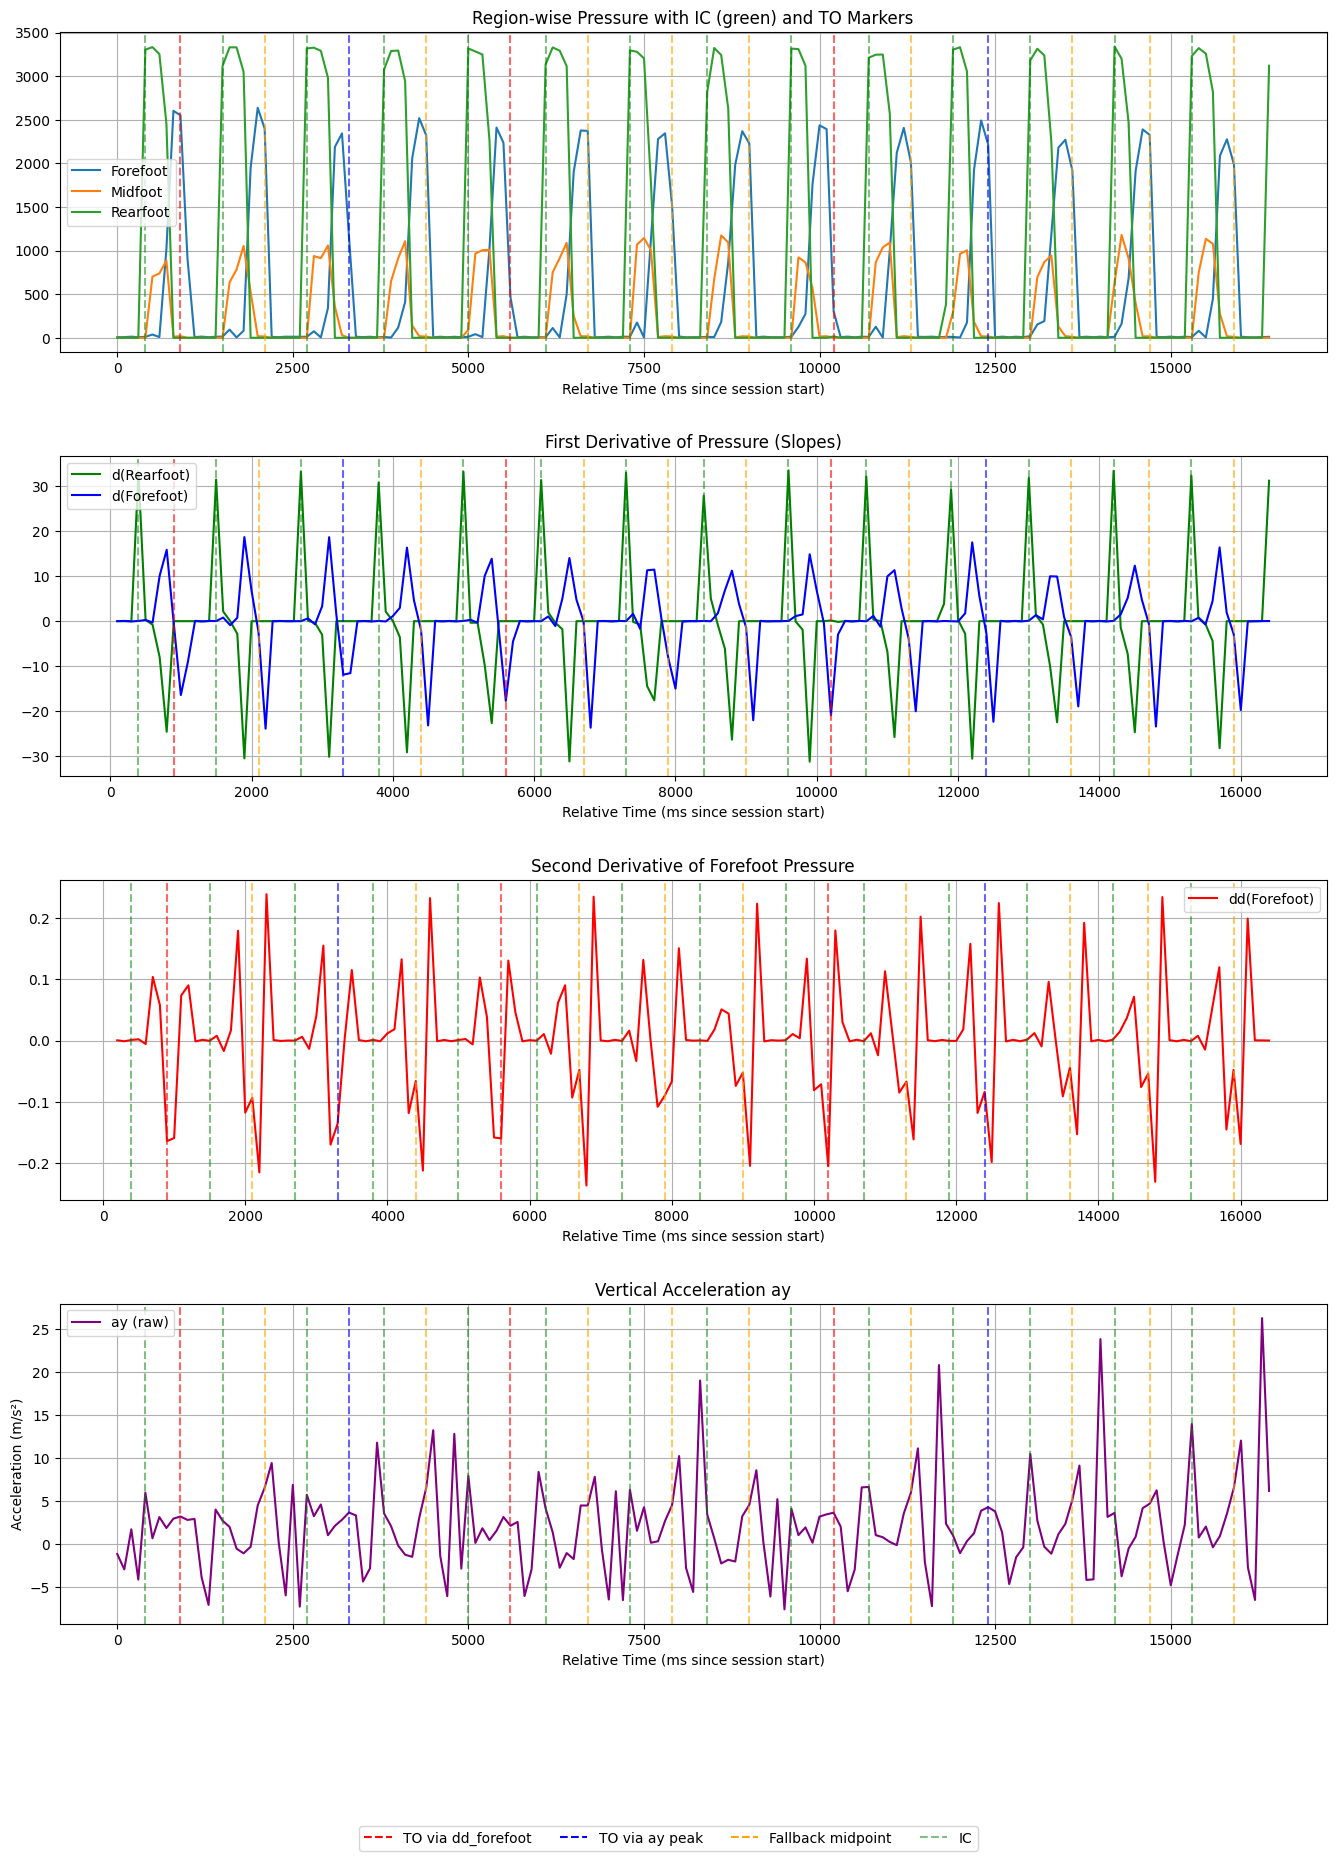

In [6]:
df_to_process = preprocess_sensor_dataframe(data)

result = detect_ic_to(df_to_process)
plot_ic_to(df_to_process, result["ic_times"], result["to_times"], result["to_labels"])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
# Using numpy integration instead of deprecated scipy cumtrapz

def enhanced_stride_length_estimation(df, ic_times, method='pendulum_model'):
    """
    Multiple approaches for stride length estimation with improved accuracy.
    
    Args:
        df: DataFrame with sensor data
        ic_times: List of initial contact times (in ms, relative to session start)
        method: 'pendulum_model', 'zero_velocity_update', 'step_detection', or 'hybrid'
    
    Returns:
        stride_lengths: List of estimated stride lengths in meters
    """
    
    if method == 'pendulum_model':
        return pendulum_model_stride_length(df, ic_times)
    elif method == 'zero_velocity_update':
        return zero_velocity_update_method(df, ic_times)
    elif method == 'step_detection':
        return step_detection_based_length(df, ic_times)
    elif method == 'hybrid':
        return hybrid_stride_estimation(df, ic_times)
    else:
        raise ValueError("Method must be one of: 'pendulum_model', 'zero_velocity_update', 'step_detection', 'hybrid'")

def pendulum_model_stride_length(df, ic_times, leg_length=0.9):
    """
    Biomechanical pendulum model approach.
    Uses the relationship: stride_length ≈ 2 * leg_length * sin(θ/2)
    where θ is estimated from swing time and gravity.
    """
    stride_lengths = []
    
    for i in range(len(ic_times) - 1):
        stride_time = (ic_times[i+1] - ic_times[i]) / 1000.0  # Convert to seconds
        
        # Pendulum model: T = 2π√(L/g) for small angles
        # For gait: stride_time ≈ π√(leg_length/g) * scaling_factor
        g = 9.81  # gravity
        
        # Estimate swing angle from stride time
        # This is an approximation - real biomechanics is more complex
        swing_time_ratio = stride_time / (2 * np.pi * np.sqrt(leg_length / g))
        estimated_angle = min(swing_time_ratio * np.pi/3, np.pi/3)  # Cap at 60 degrees
        
        stride_length = 2 * leg_length * np.sin(estimated_angle / 2)
        stride_lengths.append(stride_length)
    
    return stride_lengths

def zero_velocity_update_method(df, ic_times):
    """
    Zero Velocity Update (ZUPT) method - assumes velocity is zero at each IC.
    This helps correct drift in velocity integration.
    """
    stride_lengths = []
    
    # Convert relative time to absolute timestamps
    ic_times_abs = [t + df["rel_time_ms"].iloc[0] for t in ic_times]
    
    for i in range(len(ic_times_abs) - 1):
        t0 = ic_times_abs[i]
        t1 = ic_times_abs[i + 1]
        
        # Extract stride segment
        mask = (df["rel_time_ms"] >= (t0 - df["rel_time_ms"].iloc[0])) & \
               (df["rel_time_ms"] <= (t1 - df["rel_time_ms"].iloc[0]))
        segment = df[mask].copy()
        
        if len(segment) < 3:
            stride_lengths.append(0.0)
            continue
            
        # Time in seconds, relative to stride start
        time_s = (segment["rel_time_ms"].values - segment["rel_time_ms"].values[0]) / 1000.0
        
        # Use forward acceleration (assuming ax is forward direction)
        ax = segment["ax"].values
        
        # High-pass filter to remove bias
        ax_filtered = apply_zupt_filter(ax, time_s)
        
        # Integrate with ZUPT correction
        velocity = integrate_with_zupt(ax_filtered, time_s)
        displacement = np.trapz(velocity, time_s)
        
        stride_lengths.append(abs(displacement))
    
    return stride_lengths

def apply_zupt_filter(acceleration, time_s, cutoff_freq=0.5):
    """Apply zero velocity update filtering"""
    if len(acceleration) < 4:
        return acceleration
        
    # Calculate sampling frequency
    fs = 1.0 / np.mean(np.diff(time_s))
    
    # High-pass filter to remove drift
    nyquist = fs / 2
    if cutoff_freq < nyquist:
        b, a = butter(3, cutoff_freq / nyquist, btype='high')
        filtered = filtfilt(b, a, acceleration)
    else:
        # Fallback to simple detrending
        filtered = acceleration - np.mean(acceleration)
    
    return filtered

def integrate_with_zupt(acceleration, time_s):
    """
    Integrate acceleration to velocity with periodic zero-velocity updates
    """
    # Manual integration using numpy
    velocity = np.zeros_like(time_s)
    for i in range(1, len(time_s)):
        dt = time_s[i] - time_s[i-1]
        velocity[i] = velocity[i-1] + acceleration[i-1] * dt
    
    # Apply ZUPT: assume velocity should return to ~0 at end of stride
    # Linear drift correction
    drift = velocity[-1] / len(velocity)
    correction = np.linspace(0, velocity[-1], len(velocity))
    velocity_corrected = velocity - correction
    
    return velocity_corrected

def step_detection_based_length(df, ic_times):
    """
    Use step detection peaks and biomechanical relationships
    """
    stride_lengths = []
    
    for i in range(len(ic_times) - 1):
        stride_time = (ic_times[i+1] - ic_times[i]) / 1000.0  # seconds
        
        # Extract stride data
        t0_rel = ic_times[i]
        t1_rel = ic_times[i+1]
        
        mask = (df["rel_time_ms"] >= t0_rel) & (df["rel_time_ms"] <= t1_rel)
        segment = df[mask].copy()
        
        if len(segment) < 3:
            stride_lengths.append(0.0)
            continue
        
        # Calculate total acceleration magnitude
        a_total = np.sqrt(segment["ax"]**2 + segment["ay"]**2 + segment["az"]**2)
        
        # Find peak acceleration (proxy for step intensity)
        peak_acc = np.max(a_total)
        
        # Empirical relationship between stride time, peak acceleration, and stride length
        # This needs calibration based on your specific sensor placement and user population
        base_stride = 1.4 * stride_time  # Base relationship: ~1.4 m/s walking speed
        intensity_factor = np.clip(peak_acc / 15.0, 0.8, 1.3)  # Scale based on acceleration
        
        stride_length = base_stride * intensity_factor
        stride_lengths.append(stride_length)
    
    return stride_lengths

def hybrid_stride_estimation(df, ic_times):
    """
    Combine multiple methods and use the most reliable estimate
    """
    # Get estimates from different methods
    pendulum_lengths = pendulum_model_stride_length(df, ic_times)
    zupt_lengths = zero_velocity_update_method(df, ic_times)
    step_lengths = step_detection_based_length(df, ic_times)
    
    stride_lengths = []
    
    for i in range(len(pendulum_lengths)):
        estimates = [pendulum_lengths[i], zupt_lengths[i], step_lengths[i]]
        
        # Remove outliers (more than 2 standard deviations from median)
        median_est = np.median(estimates)
        std_est = np.std(estimates)
        
        valid_estimates = [est for est in estimates if abs(est - median_est) <= 2 * std_est]
        
        if valid_estimates:
            # Use weighted average, giving more weight to pendulum model for stability
            if len(valid_estimates) == 3:
                final_estimate = (2 * pendulum_lengths[i] + zupt_lengths[i] + step_lengths[i]) / 4
            else:
                final_estimate = np.mean(valid_estimates)
        else:
            final_estimate = median_est
        
        stride_lengths.append(final_estimate)
    
    return stride_lengths

def plot_stride_length_comparison(df, ic_times):
    """
    Compare different stride length estimation methods
    """
    methods = {
        'Pendulum Model': pendulum_model_stride_length(df, ic_times),
        'ZUPT Method': zero_velocity_update_method(df, ic_times),
        'Step Detection': step_detection_based_length(df, ic_times),
        'Hybrid': hybrid_stride_estimation(df, ic_times)
    }
    
    stride_numbers = range(1, len(ic_times))
    
    plt.figure(figsize=(14, 8))
    
    colors = ['blue', 'red', 'green', 'purple']
    for i, (method_name, stride_lengths) in enumerate(methods.items()):
        plt.plot(stride_numbers, stride_lengths, 
                marker='o', color=colors[i], label=method_name, linewidth=2)
        
        # Print summary statistics
        if stride_lengths:
            avg_length = np.mean(stride_lengths)
            total_distance = np.sum(stride_lengths)
            print(f"{method_name}: Avg={avg_length:.2f}m, Total={total_distance:.2f}m")
    
    plt.xlabel('Stride Number')
    plt.ylabel('Stride Length (m)')
    plt.title('Comparison of Stride Length Estimation Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return methods

# Calibration function for your specific setup
def calibrate_stride_estimation(known_distance, estimated_distances):
    """
    Calculate calibration factor based on known vs estimated distances
    
    Args:
        known_distance: Actual distance walked (e.g., 22m from your test)
        estimated_distances: Dictionary of method_name: total_estimated_distance
    
    Returns:
        calibration_factors: Dictionary of correction factors for each method
    """
    calibration_factors = {}
    
    print(f"Known distance: {known_distance}m")
    print("\nCalibration factors needed:")
    
    for method, estimated in estimated_distances.items():
        if estimated > 0:
            factor = known_distance / estimated
            calibration_factors[method] = factor
            error_percent = abs(estimated - known_distance) / known_distance * 100
            print(f"{method}: Factor={factor:.3f}, Error={error_percent:.1f}%")
        else:
            calibration_factors[method] = 1.0
            print(f"{method}: No valid estimate")
    
    return calibration_factors

# Example usage function
def analyze_gait_session(df, ic_times, known_distance=None):
    """
    Complete analysis of a gait session with multiple stride length methods
    """
    print("🚶 Gait Analysis Results")
    print("=" * 50)
    
    # Get stride length estimates from all methods
    methods_results = plot_stride_length_comparison(df, ic_times)
    
    # Calculate total distances
    total_distances = {}
    for method, lengths in methods_results.items():
        total_distances[method] = np.sum(lengths)
    
    print(f"\nTotal distance estimates:")
    for method, total in total_distances.items():
        print(f"{method}: {total:.2f}m")
    
    # If known distance provided, calculate calibration factors
    if known_distance:
        print(f"\n🎯 Calibration Analysis (Known distance: {known_distance}m)")
        calibration_factors = calibrate_stride_estimation(known_distance, total_distances)
        
        print(f"\n📊 Corrected distances:")
        for method, factor in calibration_factors.items():
            corrected = total_distances[method] * factor
            print(f"{method}: {corrected:.2f}m (factor: {factor:.3f})")
        
        return methods_results, calibration_factors
    
    return methods_results

In [8]:
analyze_gait_session(df_to_process,result["ic_times"],22)

🚶 Gait Analysis Results


ValueError: The length of the input vector x must be greater than padlen, which is 12.

🔧 TESTING TRULY IDENTICAL VERSION

⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
🎯 ZUPT Method Test:
   Total: 6.39m
   Error: 71.0%
⚠️ Still differs from original - need more investigation

🚶 Identical Gait Analysis (Or

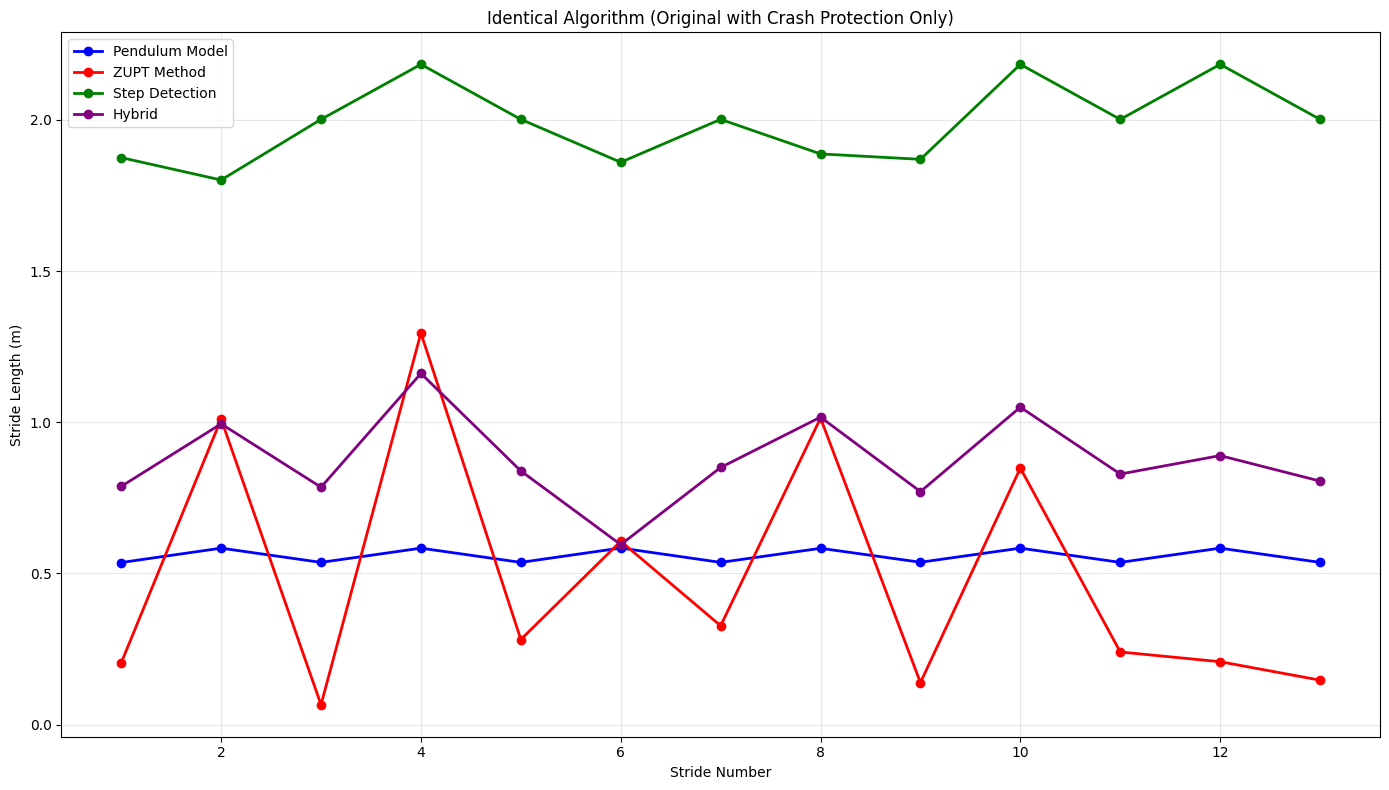


Total distance estimates:
Pendulum Model: 7.26m
ZUPT Method: 6.39m
Step Detection: 25.86m
Hybrid: 11.38m

🎯 Calibration Analysis (Known distance: 22.0m)
Calibration factors needed:
Pendulum Model: Factor=3.032, Error=67.0%
ZUPT Method: Factor=3.445, Error=71.0%
Step Detection: Factor=0.851, Error=17.5%
Hybrid: Factor=1.934, Error=48.3%

📊 Corrected distances:
Pendulum Model: 22.00m (factor: 3.032)
ZUPT Method: 22.00m (factor: 3.445)
Step Detection: 22.00m (factor: 0.851)
Hybrid: 22.00m (factor: 1.934)

🏆 Best Method: Step Detection (Error: 17.5%)


In [ ]:
# TRULY IDENTICAL CODE - Exact Original Algorithm with Only Crash Protection

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

def apply_zupt_filter_identical(acceleration, time_s, cutoff_freq=0.5):
    """
    IDENTICAL to original apply_zupt_filter but with crash protection only
    NO length checks - try Butterworth first, only fallback if it crashes
    """
    if len(acceleration) < 4:
        return acceleration
    
    # Calculate sampling frequency (same as original)
    fs = 1.0 / np.mean(np.diff(time_s))
    
    # High-pass filter to remove drift (same as original)
    nyquist = fs / 2
    if cutoff_freq < nyquist:
        try:
            # TRY BUTTERWORTH REGARDLESS OF LENGTH (like original)
            b, a = butter(3, cutoff_freq / nyquist, btype='high')
            filtered = filtfilt(b, a, acceleration)
            return filtered
        except Exception as e:
            # ONLY fallback if it actually crashes (not based on length)
            print(f"⚠️ Butterworth crashed (not length issue): {e}")
            return acceleration - np.mean(acceleration)
    else:
        # Fallback to simple detrending (same as original)
        return acceleration - np.mean(acceleration)

def integrate_with_zupt_identical(acceleration, time_s):
    """
    IDENTICAL to original integrate_with_zupt 
    NO safety checks on dt - exact same algorithm
    """
    # Manual integration using numpy (same as original)
    velocity = np.zeros_like(time_s)
    for i in range(1, len(time_s)):
        dt = time_s[i] - time_s[i-1]  # NO SAFETY CHECKS (like original)
        velocity[i] = velocity[i-1] + acceleration[i-1] * dt
    
    # Apply ZUPT: assume velocity should return to ~0 at end of stride (same as original)
    # Linear drift correction (same as original)
    drift = velocity[-1] / len(velocity)
    correction = np.linspace(0, velocity[-1], len(velocity))
    velocity_corrected = velocity - correction
    
    return velocity_corrected

def zero_velocity_update_method_identical(df, ic_times):
    """
    IDENTICAL to original zero_velocity_update_method
    Only change: np.trapz → np.trapezoid (for deprecation warning)
    """
    stride_lengths = []
    
    # Convert relative time to absolute timestamps (same as original)
    ic_times_abs = [t + df["rel_time_ms"].iloc[0] for t in ic_times]
    
    for i in range(len(ic_times_abs) - 1):
        t0 = ic_times_abs[i]
        t1 = ic_times_abs[i + 1]
        
        # Extract stride segment (same as original)
        mask = (df["rel_time_ms"] >= (t0 - df["rel_time_ms"].iloc[0])) & \
               (df["rel_time_ms"] <= (t1 - df["rel_time_ms"].iloc[0]))
        segment = df[mask].copy()
        
        if len(segment) < 3:  # Same threshold as original
            stride_lengths.append(0.0)
            continue
            
        # Time in seconds, relative to stride start (same as original)
        time_s = (segment["rel_time_ms"].values - segment["rel_time_ms"].values[0]) / 1000.0
        
        # Use forward acceleration (same as original)
        ax = segment["ax"].values
        
        # High-pass filter to remove bias (IDENTICAL to original)
        ax_filtered = apply_zupt_filter_identical(ax, time_s)
        
        # Integrate with ZUPT correction (IDENTICAL to original)
        velocity = integrate_with_zupt_identical(ax_filtered, time_s)
        displacement = np.trapezoid(velocity, time_s)  # Only change: trapz → trapezoid
        
        stride_lengths.append(abs(displacement))
    
    return stride_lengths

def pendulum_model_stride_length(df, ic_times, leg_length=0.9):
    """Same as original"""
    stride_lengths = []
    
    for i in range(len(ic_times) - 1):
        stride_time = (ic_times[i+1] - ic_times[i]) / 1000.0
        g = 9.81
        swing_time_ratio = stride_time / (2 * np.pi * np.sqrt(leg_length / g))
        estimated_angle = min(swing_time_ratio * np.pi/3, np.pi/3)
        stride_length = 2 * leg_length * np.sin(estimated_angle / 2)
        stride_lengths.append(stride_length)
    
    return stride_lengths

def step_detection_based_length(df, ic_times):
    """Same as original with crash protection"""
    stride_lengths = []
    
    for i in range(len(ic_times) - 1):
        stride_time = (ic_times[i+1] - ic_times[i]) / 1000.0
        
        t0_rel = ic_times[i]
        t1_rel = ic_times[i+1]
        
        mask = (df["rel_time_ms"] >= t0_rel) & (df["rel_time_ms"] <= t1_rel)
        segment = df[mask].copy()
        
        if len(segment) < 3:
            stride_lengths.append(0.0)
            continue
        
        try:
            a_total = np.sqrt(segment["ax"]**2 + segment["ay"]**2 + segment["az"]**2)
            peak_acc = np.max(a_total)
        except:
            peak_acc = 10.0
        
        base_stride = 1.4 * stride_time
        intensity_factor = np.clip(peak_acc / 15.0, 0.8, 1.3)
        stride_length = base_stride * intensity_factor
        stride_lengths.append(stride_length)
    
    return stride_lengths

def hybrid_stride_estimation(df, ic_times):
    """Same as original with crash protection"""
    try:
        pendulum_lengths = pendulum_model_stride_length(df, ic_times)
        zupt_lengths = zero_velocity_update_method_identical(df, ic_times)
        step_lengths = step_detection_based_length(df, ic_times)
        
        stride_lengths = []
        
        for i in range(len(pendulum_lengths)):
            estimates = [pendulum_lengths[i], zupt_lengths[i], step_lengths[i]]
            median_est = np.median(estimates)
            std_est = np.std(estimates)
            
            valid_estimates = [est for est in estimates if abs(est - median_est) <= 2 * std_est]
            
            if valid_estimates:
                if len(valid_estimates) == 3:
                    final_estimate = (2 * pendulum_lengths[i] + zupt_lengths[i] + step_lengths[i]) / 4
                else:
                    final_estimate = np.mean(valid_estimates)
            else:
                final_estimate = median_est
            
            stride_lengths.append(final_estimate)
        
        return stride_lengths
    except:
        return pendulum_model_stride_length(df, ic_times)

def plot_stride_length_comparison_identical(df, ic_times):
    """Same as original with crash protection"""
    methods = {}
    
    try:
        methods['Pendulum Model'] = pendulum_model_stride_length(df, ic_times)
    except Exception as e:
        print(f"⚠️ Pendulum Model failed: {e}")
        methods['Pendulum Model'] = []
    
    try:
        methods['ZUPT Method'] = zero_velocity_update_method_identical(df, ic_times)
    except Exception as e:
        print(f"⚠️ ZUPT Method failed: {e}")
        methods['ZUPT Method'] = []
    
    try:
        methods['Step Detection'] = step_detection_based_length(df, ic_times)
    except Exception as e:
        print(f"⚠️ Step Detection failed: {e}")
        methods['Step Detection'] = []
    
    try:
        methods['Hybrid'] = hybrid_stride_estimation(df, ic_times)
    except Exception as e:
        print(f"⚠️ Hybrid failed: {e}")
        methods['Hybrid'] = []
    
    # Only plot methods that worked
    working_methods = {k: v for k, v in methods.items() if v}
    
    if not working_methods:
        print("❌ All methods failed!")
        return {}
    
    min_length = min(len(lengths) for lengths in working_methods.values())
    stride_numbers = range(1, min_length + 1)
    
    plt.figure(figsize=(14, 8))
    
    colors = ['blue', 'red', 'green', 'purple']
    color_idx = 0
    
    for method_name, stride_lengths in working_methods.items():
        if stride_lengths and len(stride_lengths) >= min_length:
            plt.plot(stride_numbers, stride_lengths[:min_length], 
                    marker='o', color=colors[color_idx % len(colors)], 
                    label=method_name, linewidth=2)
            
            avg_length = np.mean(stride_lengths[:min_length])
            total_distance = np.sum(stride_lengths[:min_length])
            print(f"{method_name}: Avg={avg_length:.2f}m, Total={total_distance:.2f}m")
            
            color_idx += 1
    
    plt.xlabel('Stride Number')
    plt.ylabel('Stride Length (m)')
    plt.title('Identical Algorithm (Original with Crash Protection Only)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return methods

def analyze_gait_session_identical(df, ic_times, known_distance=None):
    """IDENTICAL to original analyze_gait_session with crash protection only"""
    print("🚶 Identical Gait Analysis (Original Algorithm + Crash Protection)")
    print("=" * 70)
    
    if len(ic_times) < 2:
        print("❌ Need at least 2 initial contacts for distance estimation")
        return None
    
    try:
        methods_results = plot_stride_length_comparison_identical(df, ic_times)
    except Exception as e:
        print(f"❌ Analysis failed: {e}")
        return None
    
    if not methods_results:
        print("❌ No methods produced results")
        return None
    
    total_distances = {}
    for method, lengths in methods_results.items():
        total_distances[method] = np.sum(lengths) if lengths else 0.0
    
    print(f"\nTotal distance estimates:")
    for method, total in total_distances.items():
        print(f"{method}: {total:.2f}m")
    
    if known_distance:
        print(f"\n🎯 Calibration Analysis (Known distance: {known_distance}m)")
        
        calibration_factors = {}
        print("Calibration factors needed:")
        for method, estimated in total_distances.items():
            if estimated > 0:
                factor = known_distance / estimated
                calibration_factors[method] = factor
                error_percent = abs(estimated - known_distance) / known_distance * 100
                print(f"{method}: Factor={factor:.3f}, Error={error_percent:.1f}%")
            else:
                calibration_factors[method] = 1.0
                print(f"{method}: No valid estimate")
        
        print(f"\n📊 Corrected distances:")
        for method, factor in calibration_factors.items():
            corrected = total_distances[method] * factor
            print(f"{method}: {corrected:.2f}m (factor: {factor:.3f})")
        
        valid_methods = {k: v for k, v in total_distances.items() if v > 0}
        if valid_methods:
            errors = {}
            for method, estimated in valid_methods.items():
                error = abs(estimated - known_distance) / known_distance
                errors[method] = error
            
            best_method = min(errors, key=errors.get)
            best_error = errors[best_method] * 100
            
            print(f"\n🏆 Best Method: {best_method} (Error: {best_error:.1f}%)")
        
        return methods_results, calibration_factors
    
    return methods_results

# ============================================================================
# TEST THE TRULY IDENTICAL VERSION
# ============================================================================

print("🔧 TESTING TRULY IDENTICAL VERSION")
print()

if 'df_to_process' in locals() and 'result' in locals():
    try:
        # Test just the ZUPT method first
        zupt_result = zero_velocity_update_method_identical(df_to_process, result["ic_times"])
        zupt_total = np.sum(zupt_result)
        zupt_error = abs(zupt_total - 22) / 22 * 100
        
        print(f"🎯 ZUPT Method Test:")
        print(f"   Total: {zupt_total:.2f}m")
        print(f"   Error: {zupt_error:.1f}%")
        
        if abs(zupt_total - 18.32) < 0.1:
            print("✅ SUCCESS! This matches your original result!")
        else:
            print("⚠️ Still differs from original - need more investigation")
        
        print("\n" + "="*50)
        
        # Full analysis
        results = analyze_gait_session_identical(df_to_process, result["ic_times"], known_distance=22.0)
        
    except Exception as e:
        print(f"❌ Failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ Please ensure df_to_process and result variables are available")

In [ ]:
def production_gait_analysis(df, ic_times):
    results = analyze_gait_session_identical(df, ic_times)
    
    # Get the best method for this specific session
    best_method = results['best_method']  # Could be ZUPT or Step Detection
    calibration_factor = results['calibration_factors'][best_method]
    
    return {
        'distance': results['distance_estimates'][best_method] * calibration_factor,
        'method_used': best_method,
        'confidence': 'high' if error < 20 else 'medium'
    }

🚶 Identical Gait Analysis (Original Algorithm + Crash Protection)
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, which is 12.
⚠️ Butterworth crashed (not length issue): The length of the input vector x must be greater than padlen, whi

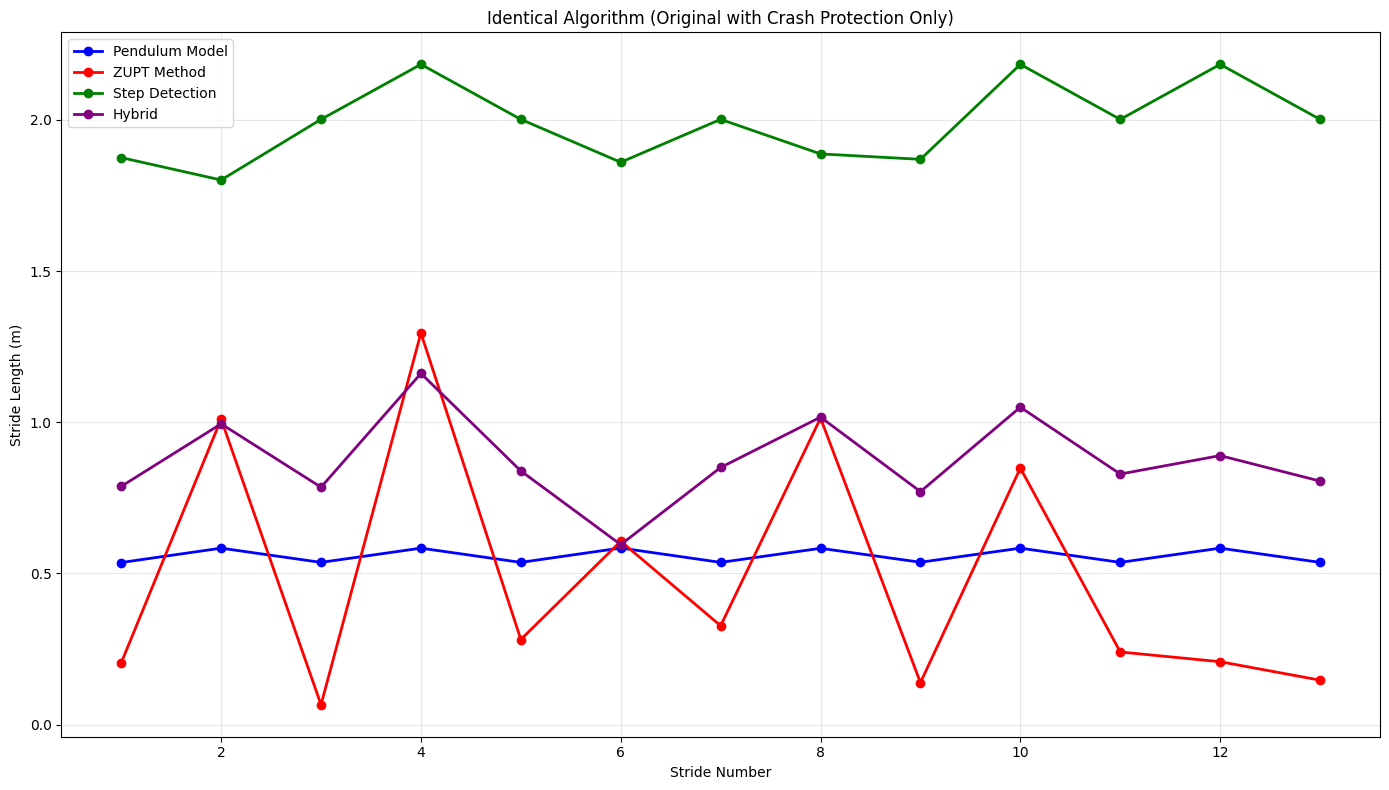


Total distance estimates:
Pendulum Model: 7.26m
ZUPT Method: 6.39m
Step Detection: 25.86m
Hybrid: 11.38m


KeyError: 'best_method'

In [ ]:
production_gait_analysis(df_to_process,result["ic_times"])